# Kaggle COVID19 California forecast
Based on https://www.kaggle.com/samkennerly/contagion-window-model

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 0

Autosave disabled


In [2]:
from datetime import timedelta
from numpy import linspace
from pathlib import Path
from pandas import DataFrame, Series, read_csv

In [3]:
FIGSIZE = (9, 5)
FOLDER = Path("../data/kaggle/california").resolve()
OUTPUT = FOLDER / 'submission.csv'
TRAIN = FOLDER / 'raw/ca_train.csv'
TEST = FOLDER / 'raw/ca_test.csv'

## get data
Load training data and forecast dates.

In [4]:
fid = (
    read_csv(TEST, parse_dates=['Date'])
    .set_index('Date')['ForecastId']
)
fid.tail()

Date
2020-04-19    39
2020-04-20    40
2020-04-21    41
2020-04-22    42
2020-04-23    43
Name: ForecastId, dtype: int64

In [5]:
train = (
    read_csv(TRAIN, parse_dates=['Date'])
    .set_index('Date')['ConfirmedCases Fatalities'.split()]
)
train.tail(16)

,ConfirmedCases,Fatalities
Date,,
2020-03-09,0.0,0.0
2020-03-10,144.0,2.0
2020-03-11,177.0,3.0
2020-03-12,221.0,4.0
2020-03-13,282.0,4.0
2020-03-14,340.0,5.0
2020-03-15,426.0,6.0
2020-03-16,557.0,7.0
2020-03-17,698.0,12.0


## model
In this example, infected persons become immediately contagious, then quarantine themselves a few days later when symptoms appear.

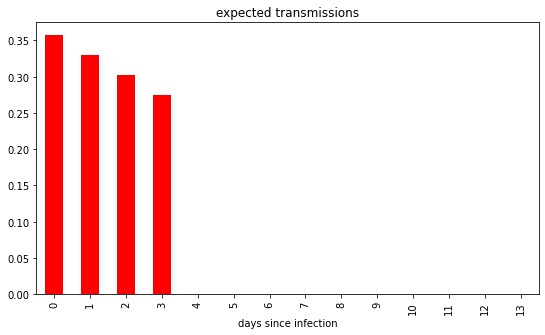

In [6]:
def contagion_window(delay=4, duration=14, reproduction=2.5, **kwargs):
    window = Series(linspace(1, 0, duration), name='window')
    window *= reproduction / window.sum()
    window[delay:] = 0
    
    return window.rename_axis('days since infection')

plotkw = {'figsize': FIGSIZE }
plotkw['color'] = 'red'
plotkw['title'] = 'expected transmissions'
axes = contagion_window().plot.bar(**plotkw)

Estimated mortality: 0.36 %


,confirmed,deceased,exposed,new
Date,,,,
2020-04-19,57792,1040,288961,28108
2020-04-20,63986,1151,319932,30971
2020-04-21,70808,1274,354044,34112
2020-04-22,78320,1409,391601,37557
2020-04-23,86586,1558,432932,41331


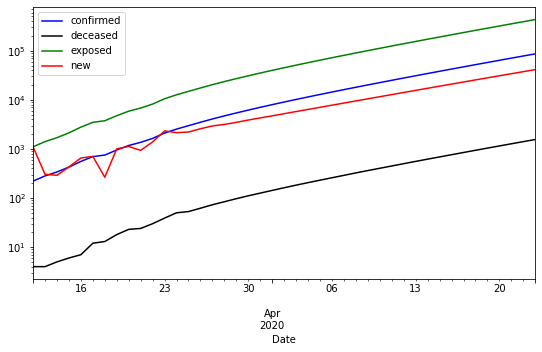

In [7]:
def convolved(values, window):
    """ int or float: Discrete convolution of two timeseries. """
    return sum( w * x for w, x in zip(window, reversed(values)) )

def tomorrow(deltas, window, population=40_000_000, vax_rate=0, **kwargs):
    """ int: Predicted number of new cases on next day. """
    sfrac = (1 - vax_rate - sum(deltas) / population )
    
    return int(sfrac * convolved(deltas, window))

def predict(train, dates, confirm_rate=0.2, **kwargs):
    """ DataFrame: Predicted future cases and fatalities. """

    aday = timedelta(days=1)
    data = DataFrame(index=dates)
    future = data.index.difference(train.index)
    window = contagion_window(**kwargs)
    duration = len(window)

    # Backfill data from training-testing overlap
    data['confirmed'] = train['ConfirmedCases']
    data['deceased'] = train['Fatalities']
    
    # Estimate infection counts and real mortality rate
    data['confirmed'] = train['ConfirmedCases']
    data['exposed'] = (train['ConfirmedCases'] / confirm_rate)
    mortality = data['deceased'].sum() / data['exposed'].sum()
    print("Estimated mortality:", round(100 * mortality, 2), "%")
 
    # Predict new cases
    data['new'] = data['exposed'].diff()
    data.at[dates.min(), 'new'] = data['exposed'][0]
    for t in future:
        deltas = data.loc[:t-aday, 'new']
        data.at[t, 'new'] = tomorrow(deltas, window, **kwargs)
        
    # Calculate cumulative totals
    loc = data.loc
    loc[future, 'exposed'] = data['new'].cumsum()
    loc[future, 'deceased'] = loc[future, 'exposed'] * mortality
    loc[future, 'confirmed'] = loc[future, 'exposed'] * confirm_rate

    return data.sort_index(axis=1).astype(int)
    
data = predict(train, fid.index)
axes = data.plot.line(color='bkgr', figsize=FIGSIZE, logy=True)
data.tail()

## submit results

In [8]:
submission = (
    DataFrame(index = data.index)
    .assign(ForecastId = fid)
    .assign(ConfirmedCases = data['confirmed'])
    .assign(Fatalities = data['deceased'])
)
print("Save", OUTPUT)
submission.to_csv(OUTPUT, index=False)
submission.tail()

Save /context/data/kaggle/california/submission.csv


,ForecastId,ConfirmedCases,Fatalities
Date,,,
2020-04-19,39,57792,1040
2020-04-20,40,63986,1151
2020-04-21,41,70808,1274
2020-04-22,42,78320,1409
2020-04-23,43,86586,1558
